# Tutoriel sur les réseaux neuronaux récurrents

## Références

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://distill.pub/2016/augmented-rnns/

https://distill.pub/about/


## Module utilitaire

Premièrement, installons pytorch et certains modules nécessaires pour compléter ce tutoriel. 

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
from random import randint
import numpy as np
import time

import torch.nn as nn
import torch.autograd as autograd
import torch.utils.data as data_utils
from torch.autograd import Variable
from torch import optim
torch.backends.cudnn.version()

import matplotlib
import matplotlib.pyplot as plt

cuda = True

torch.manual_seed(123)

In [0]:
def normalized(x, y):
  '''Cette fonction normalize un le tenseur 'x'. '''
  x = (x - torch.min(x,0)[0].view(1,x.shape[1])) / ((torch.max(x,0)[0] - torch.min(x,0)[0]).view(1,x.shape[1]))

  return x, x.sum(dim=1)

def standardized(x, y):
  '''  Cette fonction standardize un le tenseur 'x'. '''  
  x = (x - torch.mean(x, 0).view(1,x.shape[1])) / torch.std(x, 0).view(1,x.shape[1])
  
  return x, x.sum(dim=1)

def data_set(N, T, interval):
    ''' 
    inputs : 
    N : nombre de données 
    T : longueur de la séquence
    interval : l'intervalle dans lequel les nombres seront tirés pour générer les séquences. 
    
    outputs: retourne les séquences (xx) et les cibles (yy), en format torch.tensor 
    '''
    
    x = (torch.Tensor(N, T).random_(0, 2 * interval[1]) + interval[0])
   
    return x, x.sum(dim=1)
  
def print_sequence(x, y):
    '''
    x : Une séquence particulière, i.e dim(x) = 1 x T
    y : Cible liée à cette même séquence, i.e. dim(y) = 1
    retourne une série de caractères illustrant la séquence 
    dans un format convivial. 
    '''
    n = x.shape[0]
    for i, x_ in enumerate(x):
        if i == 0 : 
            string=' ' + str(x_)
        else: 
            string=string + ' + '+str(x_)

    return string+' = ' + str(y)
  
def adjust_lr(optimizer, lr0, epoch, total_epochs):
    '''
    Cette fonction diminue le taux d'apprentissage suivant une fonction 
    exponentielle avec le nombre d'époque. 
    
    optimizer: e.g. optim.SGD(... )
    lr0 : taux d'apprentissage initial
    epoch : époque à laquelle la mise à jour est effectuée. 
    total epochs: nombre d'époque totale
    
    exemple : 
    
    new_learning_rate = adjust_lr(optimizer, 0.01, e_, 100)
    
    '''
    
    lr = lr0 * (0.36 ** (epoch / float(total_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def batch_loss(data_batch,model): 
    '''
    Cette fonction calcule le loss d'un jeu de donnée divisé en plusieurs   
    batchs. C'est nécessaire pour traiter de grandes quantités de données.     
    '''
    loss = 0
    n = 0
    
    for batch_idx, (x, y) in enumerate(data_batch):
        x, y = model.input_format(x, y)
        out = model(x)
        loss += model.criterion(out, y)
        n += 1
    return loss.data[0] / n
  
  
def adjust_fontsize(ax):
  '''
  Par déformation professionnelle, j'ai le souci de préparer de belles figures. 
  Cette fonction est un clin d'oeil pour mon ancien superviseur de thèse.
  '''
  for ax in ax:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(14)  
  

## Objectif

L'objectif de ce tutoriel est de construire un modèle capable d'additionner ou soustraire une série de nombres. Ce jeu de données est facile à générer et nous permet de tester la capacité de plusieurs algorithmes tels que,

* RNN, LSTM 
* MLP


Le jeu de données est constitué d'une séquence de nombre de longueurs *seq_len* , à laquelle une cible est associée. Dans l'exemple ci-dessous, la i$^{eme}$ composante des données est explicitement détaillée (voir la Fig. 1). 

\begin{align}  
\mathrm x^{(i)} &= \left[ 4,-1,15,24\right], \mathrm x^{(i)} \in \mathbb R^{d_0} \\ 
\mathrm y^{(i)} &= 42, \mathrm y^{(i)} \in \mathbb R 
\end{align}

Il est important de noter que chaque composante du vecteur $\mathrm x^{(i)}$, peut être de plusieurs dimensions, c'est-à-dire $x^{(i)}_j \in \mathbb R^{d_1}$ où $d_1 > 1$. 


Ce jeu de donné peut ainsi servir à entrainer un modèle de réseau de neurones récurrents (RNN), tel que le _long short term memory_(LSTM). Dans ce cas, chaque nombre sera l'entrée d'une couche cachée (_hidden layer_) de dimension $h_d$. 

Comme la cible est un nombre réel, il est nécessaire de rajouter une couche linéaire au modèle pour "ajuster" les dimensions (voir la Fig.2). Cette notion sera expliquée à l'aide d'un exemple détaillé ci-bas. 

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.001.jpeg)

Fig.1 : Jeu de données considéré. 

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.002.jpeg)


Fig.2 : Schéma d'un réseau récurrent. 

## Réseau de neuronnes récurrents (LSTM)

### Générer une couche LSTM
###  __ = nn.LSTM(input_size, hidden_size, num_layers)

Une couche LSTM peut incorporer plusieurs paramètres dont certains régis par le jeu de données (*input_size*), mais aussi d'autres paramètres essentiels pour optimiser la capacité du modèle, tels que *hidden_size*, *num_layers*, etc.

### Entrés d'une couche LSTM (*inputs*)
### __ = <font color='red'>LSTM</font>(*input*, (h0,c0))

En plus des données (_input_), il est aussi possible d'initialiser les tenseurs h_0, c_0 définis comme les *hidden* et *cell states*,  paramètres essentiels aux LSTMs. 

__Dans le cas où $h_0$ et $c_0$ ne sont pas définis, le module LSTM utilisera les valeurs par défaut, i.e. 0.__

### Donnée d'entrée (*input*)
__<font color='red'>input</font> =  torch.Tensor(seq_len, batch_size, input_size) __

Il est nécessaire de réorganiser les données d'entrées (input) selon trois paramètres : 

* la longueur de la séquence (seq_len)
* la grandeur du lot (batch, i.e. batch_size)
* les dimensions des entrées (input_size)

 


### Donnée de sortie (*output*)
### output = LSTM(*input*, (h0,c0))
__<font color='red'>output</font> = torch.tensor(seq_len,batch_size, hidden_size x num_directions) __


Les dimensions du tenseur "output_0" sont déterminées par: (*seq_len*, *batch*, *hidden_size* $\times$ *num_directions*). 

Dans le cas qui nous intéresse, num_directions $ = 1$. 

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.003.jpeg)

Fig. 3: http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.004.jpeg)

Fig. 4: http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.005.jpeg)

Fig.5 : http://pytorch.org/docs/master/nn.html?highlight=lstm#torch.nn.LSTM

# Exemple

Créons un jeu de données $\bf x$ composés de 100 séquences de 4 nombres entre 0 et 100. Les cibles $\bf y$ correspondent à la somme de chacune de ces séquences. La fonction *data_set* située dans la section *Module utilitaire* s'occupe de cette tâche fastidieuse. 



In [4]:
# Création d'un jeu de donnés 
x,y = data_set(100, 4, [-100, 100])

print(x.shape)
print(y.shape)

torch.Size([100, 4])
torch.Size([100])


In [5]:
sequence = print_sequence(x[1,:] ,y[1])

print(sequence)
print('Dimensions des entrées : {} x {}'.format(*x.shape))

 80.0 + -58.0 + -14.0 + -43.0 = -35.0
Dimensions des entrées : 100 x 4


__Q1__ : Selon l'exemple ci-haut, quels sont les paramètres d'entrées? On considéra ici qu'un seul lot (*batch*). 

* batch_size = 
* seq_len = 
* input = 



In [6]:
# RÉPONSE: 
x_ = x[:,:,np.newaxis]
y_ = y[:,np.newaxis].type(torch.FloatTensor)

# ...

print('Dimensions du tenseur x = {}'.format(x_.shape))
print('______________________________________________')
print('    ')

print('Plus en détails: ')
print('_________________')
print('    ')

dimensions = x_.shape
print('batch_size = {}   seq_len = {}     input_size = {}'.format(*dimensions))

Dimensions du tenseur x = torch.Size([100, 4, 1])
______________________________________________
    
Plus en détails: 
_________________
    
batch_size = 100   seq_len = 4     input_size = 1


__Q2__  : Donnez un exemple où les dimensions d'entrées sont supérieures à un, c.-à-d. *input* $> 1$.

Réponses : 
* chaque mot d'une phrase est représenté par un vecteur de dimension égale à la grandeur du vocabulaire. 
* température réelle, vent, température ressentie vs. t
* variation boursière 

![Texte alternatif…](https://github.com/jphreid/tutorial_ivado/raw/master/lstm-figures.006.jpeg)


Fig.6 : Exemple où la dimension des entrées est supérieure à un. 

__Q3__  : Construisez votre première couche LSTM. Nous vous référons au lien dessous la Fig. 3 pour plus de détails et exemples. 

In [7]:
# Q3
# les paramètres
input_size = 1
hidden_size = 6
num_layers = 1

# lstm  
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

# forward 
output_0, (hn, cn) = lstm(Variable(x_))

print('Dimensions - output_0: {}'.format(output_0.shape))
print('Dimensions - h_n: {}'.format(hn.shape))
print('Dimensions - c_n: {}'.format(cn.shape))


Dimensions - output_0: torch.Size([100, 4, 6])
Dimensions - h_n: torch.Size([1, 100, 6])
Dimensions - c_n: torch.Size([1, 100, 6])


### Réorganiser les dimensions de la sortie ("<font color='red'>output_0</font>") 

Tel que mentionné ci-haut, seule la dernière composante du tenseur "output_0" sera considérée pour prédire la cible associée à une séquence (voir Fig.2). 

Exemple: considérons la $41^e$ séquence ainsi que la couche associée. 

In [8]:
print(x_[41,:,:])
print(y_[41])

sequence = print_sequence(x[41,:],y[41])
print(sequence)


 49
-75
-97
-32
[torch.FloatTensor of size 4x1]


-155
[torch.FloatTensor of size 1]

 49.0 + -75.0 + -97.0 + -32.0 = -155.0


In [9]:
print(output_0[41,:,:])


Variable containing:
-6.6925e-01  2.3162e-06 -6.4603e-08 -6.1620e-01 -9.2249e-05  2.0511e-07
 5.3450e-14 -2.8264e-09  8.7298e-10  2.1228e-11  1.0095e-08 -9.0937e-02
 9.6779e-18 -1.2075e-11  1.9124e-12  1.2934e-14  6.3554e-11 -6.6004e-02
 1.2787e-06 -2.7028e-04  7.1762e-05  2.4674e-05  3.3343e-04 -2.7936e-01
[torch.FloatTensor of size 4x6]



Tel que mentionné ci-haut, seule la quatrième (dernière) composante du tenseur output_0 qui doit être considéré (voir Fig. 2).

In [10]:
output_0[41,-1,:]

Variable containing:
 1.2787e-06
-2.7028e-04
 7.1762e-05
 2.4674e-05
 3.3343e-04
-2.7936e-01
[torch.FloatTensor of size 6]

Le tenseur $h_n$ regroupe la dernière sortie (*output*) de chaque séquence.

In [11]:
print(hn[:,41,:])

Variable containing:
 1.2787e-06 -2.7028e-04  7.1762e-05  2.4674e-05  3.3343e-04 -2.7936e-01
[torch.FloatTensor of size 1x6]



__Q4__  : Proposez une stratégie pour transformer le tenseur "output_0" de dimensions [100,4,6] à un tenseur de dimensions voulues, c.-à-d. [100,1]. Spécifiquement, quelle opération mathématique permettra d'obtenir les dimensions voulues? 
    * Réponse : Effectuer un produit tensoriel entre output_0 et une tenseur "M" dont le résultat est de dimensions voulues, c.-à-d. 100 x 1

\begin{align}
\text{output} =  \text{output_0}\;  M 
\end{align}
Dans le cas qui nous intéresse, les dimensions du tenseur "M" sont de $1 \times$ *hidden_size* 


In [12]:
## Question

'''
Première partie: générez un tenseur M de dimensions voulues et utilisez 
la fonction 'torch.matmul' pour  multiplier M et output_0. 

Indice : Le tenseur M doit être une 'Variable' pour être multiplié au tenseur 
output_0

M = Variable(torch.Tensor( _?_, _?_ ))
output = torch.matmul(output_0}[_?_, _?_, _?_], M)

'''
M = Variable(torch.Tensor(hidden_size, 1))
output = torch.matmul(output_0[:,-1,:], M)

'''
Deuxième partie: gérérez une couche linéaire de dimensions voulues avec la 
fonction 'LL = nn.Linear(_?_, _?_, _?_)'. 

L'entrée de LL sera output_0, i.e. output = LL(output_0[_?_, _?_, _?_])
''' 

LL = nn.Linear(hidden_size, input_size,bias=True)
output = LL(output_0[:,-1,:])
print(output.shape)

torch.Size([100, 1])


### Construction du modèle

Il est fortement suggéré d'utiliser des classes pour définir les modèles dans l'environnement Pytorch, et ce peu importe son architecture. 


__Q5__  : Écrivez la fonction RnnLinear.forward(). Cette fonction aura comme entrée *self* et le tenseur $\bf x$ de dimension N x T x 1. 

Indice : le output_0 de la couche LSTM ou RNN sera l'entrée de la couche linéaire. 




In [0]:
class RnnLinear(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, lstm_or_rnn,cuda):
        '''
        Les paramètres importants du modèle sont définies dans cette fonction. 
        '''
        num_directions = 1
        super(RnnLinear, self).__init__()
        
        # parametres importants 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_or_rnn = lstm_or_rnn      
        
        # couches de notre réseau 
        if lstm_or_rnn == 'lstm':
            self.lstm = nn.LSTM(input_size, hidden_size, 
                                num_layers,dropout = 0.5,
                                batch_first = True)
            if cuda : self.lstm.cuda() 
              
        elif lstm_or_rnn == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size,
                              num_layers,dropout = 0.5, 
                              batch_first = True
                             )
            if cuda: self.rnn.cuda()
              
        else: print('You made a mistake, pal!')
        
        self.linear = nn.Linear(hidden_size, input_size,bias=True)
        if cuda: self.linear.cuda()
              
        # criteria for SGD
        self.criterion = nn.MSELoss()
        
    def input_format(self,x,y):
        '''
        Cette fonction permet de préparer les dimensions des données d'entrées. 
        '''
        x = x[:,:,np.newaxis]
        y = y[:,np.newaxis].type(torch.FloatTensor)
        
        if cuda : 
            x = Variable(x.cuda())
            y = Variable(y.cuda())
            
        else: 
            x = Variable(x)
            y = Variable(y)
        return x,y

    def grad_norm(self):
        total_norm=0
        for p in list(self.parameters()):
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm

        return total_norm
  
    def forward(self,x):
        '''
        Cette fonction devrait inclure des conditions if/elif sur la variable 
        self.lstm_or_rnn. La sortie des couches LSTM et RNN seront les entrées 
        de la couche linéaire. 
        '''
        
        # cas où self.lstm_or_rnn = 'rnn'
        if self.lstm_or_rnn == 'rnn':
            out1,(__) = self.rnn(x)

        # cas où self.lstm_or_rnn = 'lstm'      
        if self.lstm_or_rnn == 'lstm':
            out1,(__) = self.lstm(x)

        # votre couche linéraire             
        out2 = self.linear(out1[:,-1,:])

        return out2

Testons notre modèle!

Prenez le temps de bien comprendre les dimensions affichées ci-bas. 

In [14]:
x,y = data_set(100, 4, [0,100])


input_size = 1
num_layers = 2
hidden_size = 40 

model = RnnLinear(input_size, hidden_size, num_layers, 'lstm', cuda)

xx,yy = model.input_format(x, y)
print('Dimensions initiales des données : {}'.format(x.shape))
print('Dimensions des données formatées : {}'.format(xx.shape))

pred = model(xx)
print('Dimensions des prédictions : {}'.format(pred.shape))

Dimensions initiales des données : torch.Size([100, 4])
Dimensions des données formatées : torch.Size([100, 4, 1])
Dimensions des prédictions : torch.Size([100, 1])


### Questions

__Q6__

Construisez la boucle d'entrainement ci-bas. 

__Q7__

Entrainez le modèle sur 20 époques avec ces paramètres et hyperparamètres, c.-à-dire $N_{train}$ = 20000, T = 10, intervalle = [0,1000], $h_d$ = 20, num_layers = 2, lr0 = 0.05. 

__Q8__ : 

Testez le modèle sur l'ensemble de test. Commentez les résultats obtenus.  

Note: L1 loss est définie comme la somme des différences absolue entre les cibles et les prédictions. Pour l'ensemble de test considéré, cette quantité est définie comme \begin{align}
L1 = \sum_{i=1}^{5000} \mid y^{(i)} - \text{output}^{(i)}\mid \end{align}

__Q9__ 

Augmentez la capacité du modèle, en fixant $h_d$ = 40. Comparez les résultats à ceux précédents.

__Q10__ 

Finalement, *'standardisez'* les données de chaque séquence. Vous devrez utiliser la fonction *x, y = standardized(x, y)* définie dans le module utilitaire. 

De plus, élargissez l'intervalle de tirage de -1000 à 1000 et entrainez jusqu'à 100 époques. Comparez les résultats à ceux précédents.

__Q11__

Il est possible d'activer ou de désactiver l'option dropout de notre modèle en appelant 'model.train()' et 'model.eval()' respectivement. Testez ces deux modes. 

Pourquoi est-il nécessaire de désactiver l'option 'dropout' lors des phases test et validation? 

__Q12__ 

Explorez différents hyperparamètres. 

* lr = 0.1, 1, 0.00001

* hidden_size = 100,150, 200

* dropout = 0.1, 0.3, 0.5

Enjoy! 



### Création du jeu de données

In [0]:
x,y = data_set(20000, 10, [0,1000])

#  standardized
xtrain, ytrain = (x[:10000], y[:10000])
xvalid, yvalid = (x[10000:15000], y[10000:15000])
xtest, ytest = (x[15000:], y[15000:])

batch_size = 100

all_data_train = data_utils.DataLoader(data_utils.TensorDataset(xtrain, ytrain),
                                       batch_size, shuffle=True)
all_data_valid = data_utils.DataLoader(data_utils.TensorDataset(xvalid, yvalid), 
                                       batch_size, shuffle=False)
all_data_test = data_utils.DataLoader(data_utils.TensorDataset(xtest, ytest),
                                       batch_size, shuffle=False)

### Entraînement du modèle

In [16]:
input_size = 1
num_layers = 2
hidden_size = 20
number_epoch = 20
lr0 = 0.05

model = RnnLinear(input_size, hidden_size, num_layers,'lstm',cuda)
optimizer = optim.SGD(model.parameters(),lr=lr0)


t0 = time.clock()

# tableau à remplir lors de la phase d'entrainement 
loss_train_data = np.array([]) 
loss_valid_data = np.array([]) 

total_norm = np.array([])

t0 = time.clock()  

for e_ in range(number_epoch):
  
  # model.train(), poruquoi? Indice : dropout   
  model.train()
  for batch_idx, (xx, yy) in enumerate(all_data_train):                
    # Formatez les données
    xx,yy = model.input_format(xx,yy)
    
    # Évaluez le modèle 
    pred_batch = model(xx)
    
    # Initialisez les gradients
    optimizer.zero_grad()
    
    # Calculez la loss  
    loss_batch = model.criterion(pred_batch,yy)
    
    # SGD backward 
    loss_batch.backward()
    
    # SGD optimized
    optimizer.step()
    
    # stop. 
  
  # Calculez la norm de tous les gradients 
  total_norm = np.append(total_norm,model.grad_norm())

  # model.eval(), pourquoi? Indice : dropout 
  model.eval()  

  loss_train_data = np.append(loss_train_data, batch_loss(all_data_train,model)) 
  loss_valid_data = np.append(loss_valid_data, batch_loss(all_data_valid,model))

  if e_%10 == 0: 
    # '{} {}'.format('foo', 'bar')
    print('N. of Epochs = {}, Train Loss = {}, Valid Loss = {}'.format(e_, loss_train_data[e_], loss_valid_data[e_]))


  lr_ = adjust_lr(optimizer, lr0, e_, number_epoch)

tf = time.clock()
print('Terminé, {} sec'.format(tf-t0))

N. of Epochs = 0, Train Loss = 3366136.32, Valid Loss = 3247932.48
N. of Epochs = 10, Train Loss = 3354836.16, Valid Loss = 3242021.44
Terminé, 16.876976000000003 sec


### Prédiction du modèle

In [17]:
# prêt pour évaluer
model.eval()

# prêt pour entraîner
# model.train()

xtest_,ytest_ = model.input_format(xtest, ytest)
pred_test_all = model(xtest_)

L1_loss = torch.sum(torch.abs(pred_test_all - ytest_)).data[0]

print('LSTM L1 loss = {}'.format(L1_loss))
print('      ')
print('Prediction')
print('___________________')
print(pred_test_all[0:10])
print('      ')
print('Target')
print('___________________')
print(ytest_[:10])

LSTM L1 loss = 7298586.0
      
Prediction
___________________
Variable containing:
 9977.2266
 9977.2266
 9977.2266
 9977.2266
 9977.2266
 9977.2266
 9977.2266
 9977.2266
 9977.2266
 9977.2266
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]

      
Target
___________________
Variable containing:
  5675
 12965
  7010
  4584
  7755
  9019
  9462
 10744
  6914
 11389
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]



### Courbes d'apprentissage

Nous traçons plus bas deux graphiques d'importance capitale : 

* Courbe d'apprentissage, i.e. loss vs. époque pour l'ensemble de validation et d'entrainement. 
* La norme de tous les gradients évaluée à chaque époque. 


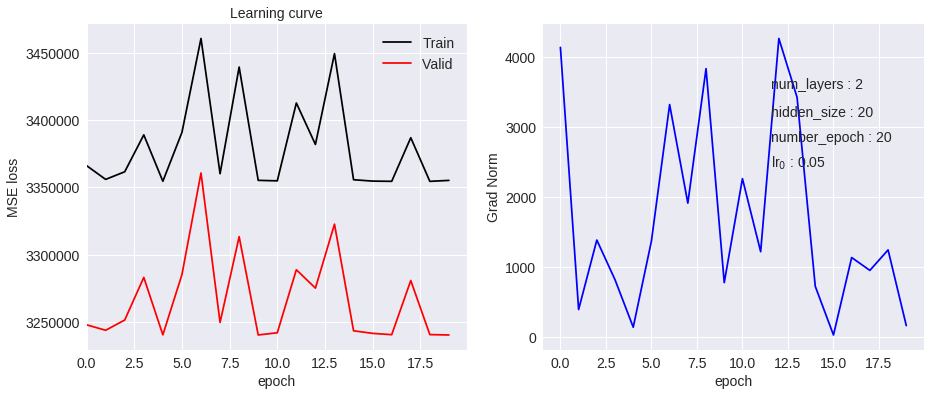

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.plot(loss_train_data,'-k',label='Train')
ax1.plot(loss_valid_data,'-r',label='Valid')

ax2.plot(total_norm,'-b',label='Grad')


ax1.set_xlabel('epoch',fontsize=14)
ax2.set_xlabel('epoch',fontsize=14)
ax1.set_ylabel('MSE loss',fontsize=14)	
ax2.set_ylabel('Grad Norm',fontsize=14)	
legend = ax1.legend(loc='upper right',fontsize=14)

ax1.set_xlim((0))

ax1.set_title('Learning curve', fontsize = 14)
ax1.set_title('Learning curve', fontsize = 14)

xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()

ax2.text(0.6*(xmax - xmin) + xmin, 0.8*(ymax-ymin) + ymin,
         'num_layers : '+str(num_layers), fontsize=14)

ax2.text(0.6*(xmax - xmin) + xmin, 0.72*(ymax-ymin) + ymin,
         'hidden_size : '+str(hidden_size), fontsize=14)

ax2.text(0.6*(xmax - xmin) + xmin, 0.64*(ymax-ymin) + ymin,
         'number_epoch : '+str(number_epoch), fontsize=14)

ax2.text(0.6*(xmax - xmin) + xmin, 0.56*(ymax-ymin) + ymin,
         'lr$_0$ : '+str(lr0), fontsize=14)


adjust_fontsize([ax1,ax2])
plt.show()          





### Question

__Q13__ : Dans le graphique ci-haut, comment expliquez-vous que la norme diminue et converge vers zéro avec le nombre d'époques? 

...

## Prédiction sur des séquences de longueurs différentes

### Question

__Q14__ : Prouvez qu'il est aussi possible d'utiliser le modèle entrainé pour prédire des séquences d'une longueur différente.

In [19]:
T_= 12
# xtrain, ytrain = normalized(x[:20000], y[:20000])

xx, yy = data_set(500,T_,[0,100])
xx, yy = normalized(xx, yy)

xx, yy = model.input_format(xx, yy)

print('Séquence de longueur {}'.format(T_))
print('--------------------------')
print('Prédiction: {}'.format(model(xx).data[0][0]))

print('Cible: {}'.format(yy.data[0][0]))
print('LSTM L1 loss: {}'.format((torch.abs(model(xx).data[0]-yy.data[0])[0])))

Séquence de longueur 12
--------------------------
Prédiction: 9977.2265625
Cible: 4.9005889892578125
LSTM L1 loss: 9972.326171875


# Comparaison entre RNN et LSTM


__Q15__ : Entrainez le modèle ci-bas pour ces séries d'hyperparamètres et comparez les performances des modèles RNN et LSTM. 

* 'Stardardized' les données. 
* N = 30000
* $h_d$ = 50
* number_epoch = 100
* batch_size = 100
* lr0 = 0.005

  * T = 20, 50, 100, 200
  





In [26]:
cuda = True 

input_size = 1
num_layers = 2
hidden_size = 50
number_epoch = 20
batch_size = 100
lr0 = 0.005

loss_train_data_rnn = np.array([])
loss_train_data_lstm = np.array([])

loss_valid_data_rnn = np.array([])
loss_valid_data_lstm = np.array([])

total_norm_rnn = np.array([])
total_norm_lstm = np.array([])

# Génération des données
T = 20

x,y = data_set(30000, T, [-10000,10000])

xtrain, ytrain = standardized(x[:20000], y[:20000])
xvalid, yvalid = standardized(x[20000:25000], y[20000:25000])
xtest, ytest = standardized(x[25000:], y[25000:])

batch_size = 100

all_data_train = data_utils.DataLoader(data_utils.TensorDataset
                          (xtrain, ytrain),batch_size, shuffle=True)
  
all_data_valid = data_utils.DataLoader(data_utils.TensorDataset
                          (xvalid, yvalid),batch_size, shuffle=False)

all_data_test = data_utils.DataLoader(data_utils.TensorDataset
                          (xtest, ytest),batch_size, shuffle=False)

# Initialisation des modèeles
model_rnn = RnnLinear(input_size, hidden_size, num_layers, 'rnn', cuda)
model_lstm = RnnLinear(input_size, hidden_size, num_layers, 'lstm', cuda)
optimizer_rnn = optim.SGD(model_rnn.parameters(), lr=lr0)
optimizer_lstm = optim.SGD(model_lstm.parameters(), lr=lr0)

t0 = time.clock()  
for e_ in range(number_epoch):  

  model_rnn.train()
    
  ##################
  ###### RNN ######
  ##################
    
  for batch_idx, (xx, yy) in enumerate(all_data_train):                
    xx, yy = model_rnn.input_format(xx, yy)
    pred_batch_rnn = model_rnn(xx)
    optimizer_rnn.zero_grad()
    loss_batch_rnn = model_rnn.criterion(pred_batch_rnn, yy)
    loss_batch_rnn.backward()
#     torch.nn.utils.clip_grad_norm(model_rnn.parameters(), 0.2, norm_type=2)
    optimizer_rnn.step()

  model_rnn.eval()
  lt = batch_loss(all_data_train, model_rnn)
  lv = batch_loss(all_data_valid, model_rnn)
  loss_train_data_rnn = np.append(loss_train_data_rnn, lt)
  loss_valid_data_rnn = np.append(loss_valid_data_rnn, lv)
    
  total_norm_rnn = np.append(total_norm_rnn,model_rnn.grad_norm())
    
  ##################
  ###### LSTM ######
  ##################
    
  model_lstm.train()
  for batch_idx, (xx, yy) in enumerate(all_data_train):
    xx,yy = model_lstm.input_format(xx, yy)
    pred_batch_lstm = model_lstm(xx)
    optimizer_lstm.zero_grad()
    loss_batch_lstm = model_lstm.criterion(pred_batch_lstm,yy)
    loss_batch_lstm.backward()
#     torch.nn.utils.clip_grad_norm(model_lstm.parameters(), 0.2, norm_type=2)
    optimizer_lstm.step()
  
    
  model_lstm.eval()
  lt = batch_loss(all_data_train, model_lstm)
  lv = batch_loss(all_data_valid, model_lstm)
  loss_train_data_lstm = np.append(loss_train_data_lstm, lt)
  loss_valid_data_lstm = np.append(loss_valid_data_lstm, lv)
  
  total_norm_lstm = np.append(total_norm_lstm, model_lstm.grad_norm())  
  
  ##################
  ##################
    
  if e_%10 == 0: 
    print('N. of Epochs # {}, RNN, Train loss = {}  ----    LSTM, Train loss = {}'
            .format(e_,loss_train_data_rnn[e_],loss_train_data_lstm[e_]))
    
  lr_ = adjust_lr(optimizer_rnn,lr0, e_, number_epoch)
  lr_ = adjust_lr(optimizer_lstm,lr0, e_, number_epoch)
    
  tf = time.clock()
print('Terminé, %.1f sec'%(tf - t0))

N. of Epochs # 0, RNN, Train loss = 9.63027587890625  ----    LSTM, Train loss = 20.1051513671875
N. of Epochs # 10, RNN, Train loss = 0.4117207717895508  ----    LSTM, Train loss = 0.19798406600952148
Terminé, 98.7 sec


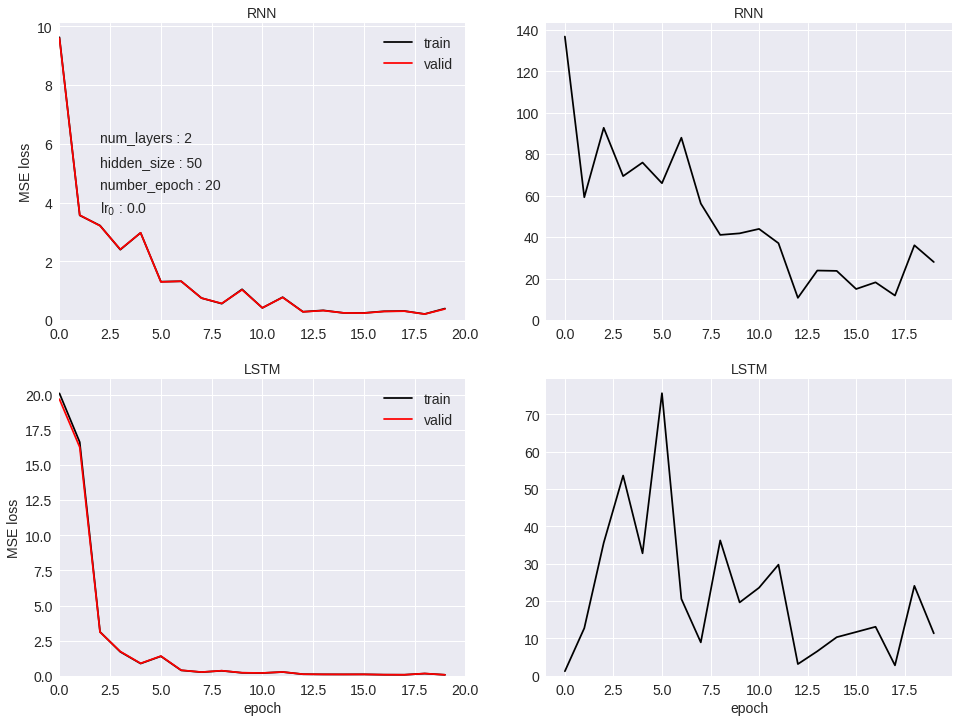

In [27]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,12))
ax1.plot(loss_train_data_rnn, '-k', label ='train')
ax1.plot(loss_valid_data_rnn, '-r', label = 'valid')

ax2.plot(total_norm_rnn, '-k', label = 'norm rnn')

ax3.plot(loss_train_data_lstm, '-k', label ='train')
ax3.plot(loss_valid_data_lstm, '-r', label = 'valid')

ax4.plot(total_norm_lstm, '-k', label = 'norm lstm')

ax3.set_xlabel('epoch', fontsize=14)
ax4.set_xlabel('epoch', fontsize=14)

ax1.set_ylabel('MSE loss', fontsize=14)	
ax3.set_ylabel('MSE loss', fontsize=14)	

ax1.set_title('RNN', fontsize = 14)
ax2.set_title('RNN', fontsize = 14)
ax3.set_title('LSTM', fontsize = 14)
ax4.set_title('LSTM', fontsize = 14)
legend = ax1.legend(loc='upper right', fontsize=14)
legend = ax3.legend(loc='upper right', fontsize=14)


ax1.set_xlim((0,number_epoch))
ax1.set_ylim((0))
ax2.set_ylim((0))
ax3.set_xlim((0,number_epoch))
ax3.set_ylim((0))
ax4.set_ylim((0))

xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()

ax1.text(0.1*(xmax - xmin) + xmin, 0.6*(ymax-ymin) + ymin,
         'num_layers : %.f'%num_layers, fontsize=14)
ax1.text(0.1*(xmax - xmin) + xmin, 0.52*(ymax-ymin) + ymin,
         'hidden_size : %.f'%hidden_size, fontsize=14)
ax1.text(0.1*(xmax - xmin) + xmin, 0.44*(ymax-ymin) + ymin,
         'number_epoch : %.f'%number_epoch, fontsize=14)
ax1.text(0.1*(xmax - xmin) + xmin, 0.36*(ymax-ymin) + ymin,
         'lr$_0$ : %.1f'%lr0, fontsize=14)


for ax in [ax1,ax2,ax3,ax4]:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
               + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()          
    

# MLP

Pour la suite, nous vous proposons d'intégrer ce jeu de données à un MLP, tel que présenté par Arsène Fansi Tchango.

Voici les données : 


In [0]:
def linear_ini(ll,initialization):
    '''
    inputs : linear layer (ll) and the initialization
    output : linear layer with the chosen initialization
    '''
    if initialization == 'glorot':
        ll.weight.data = nn.init.xavier_uniform(ll.weight.data, gain=1)
        ll.bias.data = nn.init.constant(ll.bias.data, 0)
    return ll

def prediction_batch(data_batch, model):
  loss = 0
  n = 0
  for x,y in data_batch:
    
    out = 0
    x,y = model.input_shape(x, y)
    pred_batch = model(x)          
    loss_batch = model.criterion(pred_batch, y)
    loss += loss_batch
    n += y.shape[0]
    
  return loss.data[0] / n
  
  
class MLPLinear(nn.Module):
  def __init__(self, dimensions, cuda):
    super(MLPLinear, self).__init__()
    self.h0 = int(dimensions[0])
    self.h1 = int(dimensions[1])
    self.h2 = int(dimensions[2])       
    self.h3 = int(dimensions[3])       
    
    self.fc1 = torch.nn.Linear(self.h0, self.h1)
    self.fc2 = torch.nn.Linear(self.h1, self.h2)
    self.fc3 = torch.nn.Linear(self.h2, self.h3)
    
    self.relu = nn.ReLU()
    self.criterion = nn.MSELoss()
    self.cuda = cuda

    if cuda: 
      self.fc1.cuda()
      self.fc2.cuda()
      self.fc3.cuda()
      self.relu.cuda()
      self.criterion.cuda()

  def initialization(self,method):
    self.fc1 = linear_ini(self.fc1, method)
    self.fc2 = linear_ini(self.fc2, method)
    self.fc3 = linear_ini(self.fc3, method)

  def input_shape(self, x, y):  
    y = y.float()
    
    if self.cuda : 
      x = Variable(x.cuda())
      y = Variable(y.cuda())
    else: 
      x = Variable(x)
      y = Variable(y)
    return x,y

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.fc3(out)    
    return  out
  
  

In [0]:
T = 30
x,y = data_set(20000, T, [-1000,1000])

x = torch.FloatTensor(x)
y = torch.FloatTensor(y).long()

xtrain, ytrain = standardized(x[:10000], y[:10000])
xvalid, yvalid = standardized(x[10000:15000], y[10000:15000])
xtest, ytest = standardized(x[15000:], y[15000:])

batch_size = 100

all_data_train = data_utils.DataLoader(data_utils.TensorDataset(xtrain, ytrain),
                                       batch_size, shuffle=True)
all_data_valid = data_utils.DataLoader(data_utils.TensorDataset(xvalid, yvalid), 
                                       batch_size, shuffle=False)
all_data_test = data_utils.DataLoader(data_utils.TensorDataset(xtest, ytest),
                                       batch_size, shuffle=False)

In [24]:

cuda = True
lr0 = 0.01
batch_size = 100
nb_epochs = 300

# weight_decay_0 = 2.5 * batch_size / xtrain.shape[0]		
model = MLPLinear([T, 300, 200, 1], cuda) 
model.initialization('glorot')

optimizer = optim.SGD(model.parameters(), lr=lr0)	

loss_train = np.empty((nb_epochs)) 
loss_valid = np.empty((nb_epochs)) 

L2norm = np.empty((nb_epochs))		

for e_ in range(nb_epochs):
  for batch_idx, (x, y) in enumerate(all_data_train):
    loss_batch=0
    xt,yt = model.input_shape(x, y)
    pred_batch = model(xt)          
    optimizer.zero_grad()
    loss_batch = model.criterion(pred_batch, yt)
    loss_batch.backward()
    loss_batch += loss_batch
    optimizer.step()				
  loss_train[e_] = prediction_batch(all_data_train ,model)
  loss_valid[e_] = prediction_batch(all_data_valid, model)
  if e_%20==0: 
    print('Epoch #{}, Loss train = {}, Loss valid = {}'.format(e_, loss_train[e_], loss_valid[e_]))
    
print('Done!')

Epoch #0, Loss train = 0.0014478420257568359, Loss valid = 0.001552576160430908
Epoch #20, Loss train = 0.00020249600410461425, Loss valid = 0.00030281074047088625
Epoch #40, Loss train = 0.00013503018617630006, Loss valid = 0.00023837995529174804
Epoch #60, Loss train = 0.00010209981203079223, Loss valid = 0.0002047806978225708
Epoch #80, Loss train = 8.174306750297547e-05, Loss valid = 0.00017939406633377076
Epoch #100, Loss train = 6.990192532539368e-05, Loss valid = 0.0001621128797531128
Epoch #120, Loss train = 5.948930978775025e-05, Loss valid = 0.00014769413471221924
Epoch #140, Loss train = 5.241090655326843e-05, Loss valid = 0.00013490887880325317
Epoch #160, Loss train = 4.6307921409606934e-05, Loss valid = 0.00012522404193878174
Epoch #180, Loss train = 4.1766953468322755e-05, Loss valid = 0.00011731381416320801
Epoch #200, Loss train = 3.811548054218292e-05, Loss valid = 0.00011010390520095826
Epoch #220, Loss train = 3.47454309463501e-05, Loss valid = 0.0001026433110237121

In [25]:
model.eval()

xtest_, ytest_ = model.input_shape(xtest, ytest)
pred_test_all = model(xtest_).view(xtest_.shape[0])

L1_loss = torch.sum(torch.abs(pred_test_all - ytest_)).data[0]

print('LSTM L1 loss = {}'.format(L1_loss))
print('      ')
print('Prediction')
print('___________________')
print(pred_test_all[:10])
print('      ')
print('Target')
print('___________________')
print(ytest_[:10])

LSTM L1 loss = 378.07879638671875
      
Prediction
___________________
Variable containing:
  4.4446
  5.5161
  0.2278
  7.5555
 -0.3784
  0.8023
  1.5729
 -0.7211
  6.8310
-11.6562
[torch.cuda.FloatTensor of size 10 (GPU 0)]

      
Target
___________________
Variable containing:
  4.3120
  5.4063
  0.1567
  7.3945
 -0.4228
  0.8341
  1.6825
 -0.8382
  6.8922
-11.6883
[torch.cuda.FloatTensor of size 10 (GPU 0)]

